# Análisis de Evasión según Variables Numéricas - Telecom X

## Propósito
En este cuaderno, se analiza cómo se distribuyen las variables numéricas (`Antigüedad`, `Cargos_Mensuales`, `Cargos_Totales`, `Cargos_Diarios`) entre clientes que cancelaron (`Evasión = 1`) y los que no (`Evasión = 0`). Se utilizan histogramas y boxplots para identificar patrones asociados con la evasión.

## Tarea
1. Cargar el dataset estandarizado desde la URL de la API y aplicar transformaciones previas.
2. Crear histogramas y boxplots para las variables numéricas, comparando `Evasión = 0` y `Evasión = 1`.
3. Guardar las visualizaciones como PNG en la carpeta `img/`.
4. Interpretar los patrones observados.

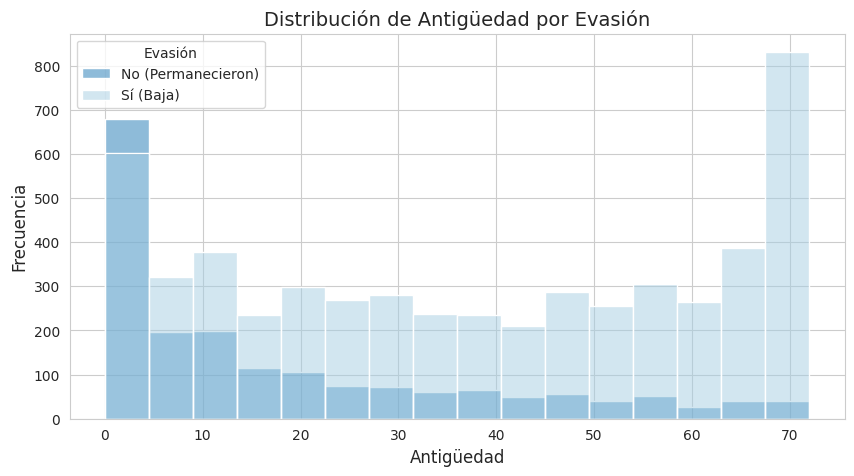

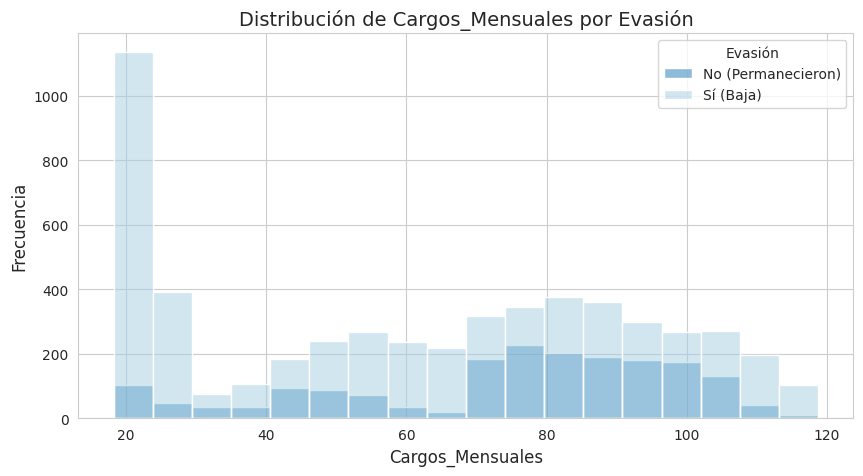

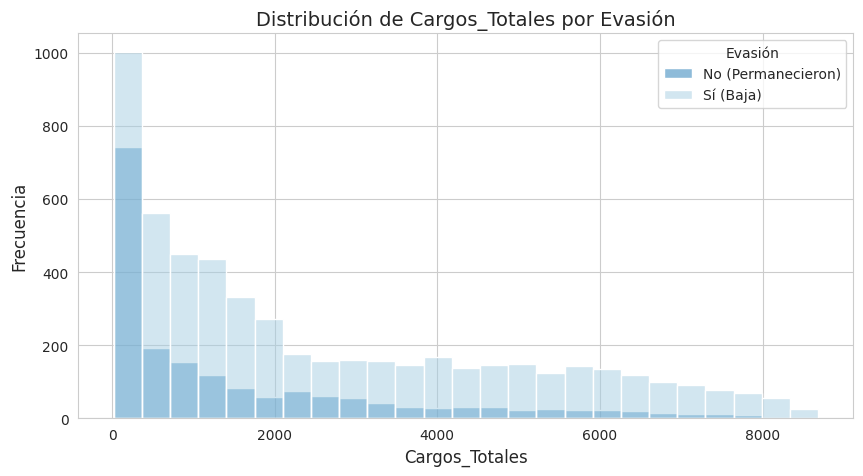

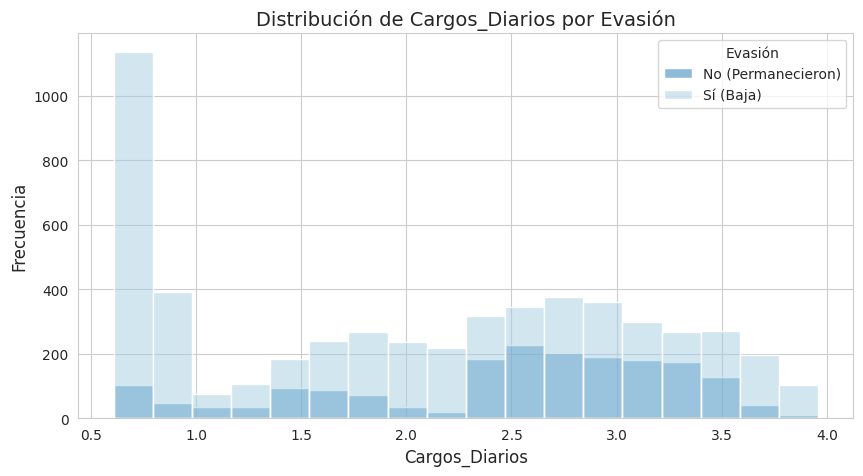

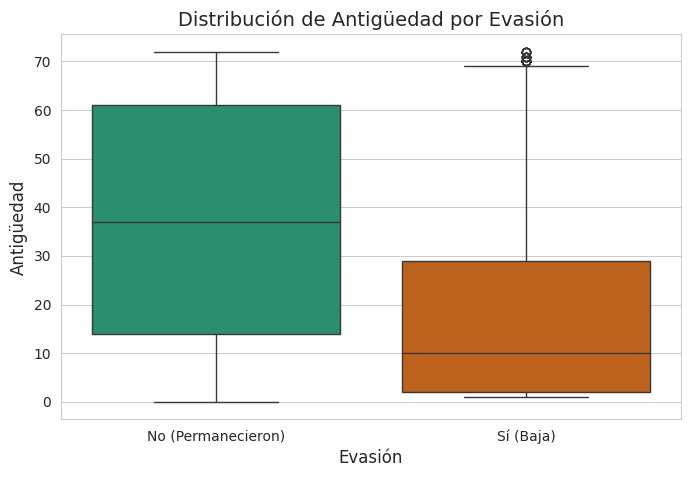

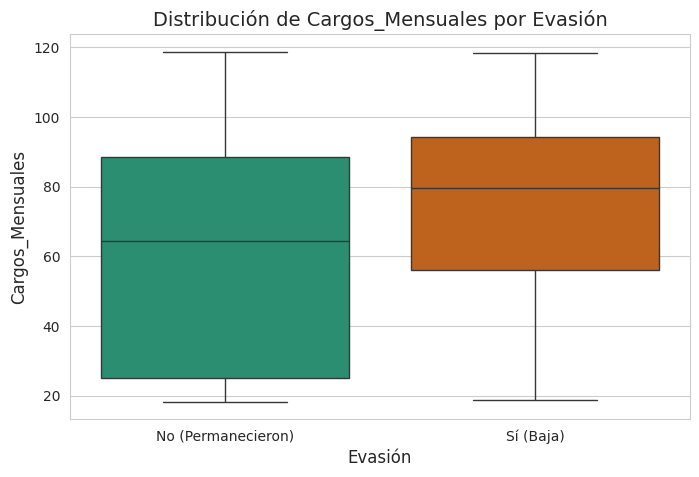

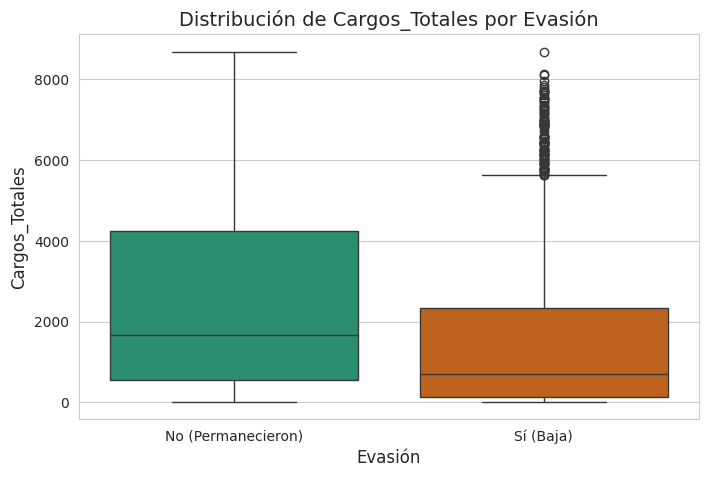

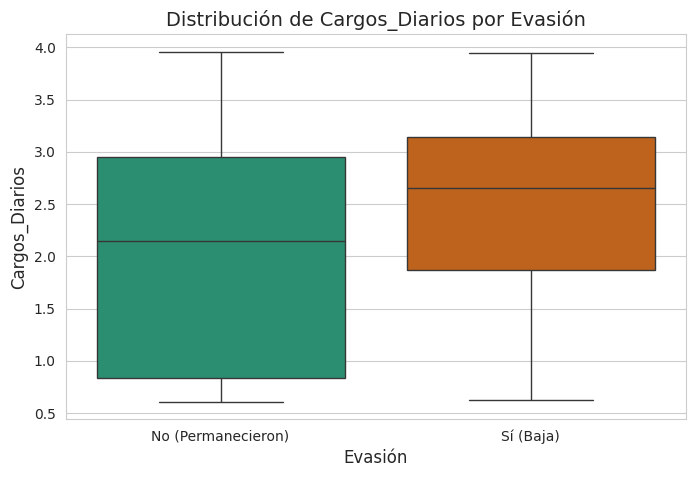


Gráficos guardados como:
- evasion_antiguedad_hist.png
- evasion_antiguedad_box.png
- evasion_cargos_mensuales_hist.png
- evasion_cargos_mensuales_box.png
- evasion_cargos_totales_hist.png
- evasion_cargos_totales_box.png
- evasion_cargos_diarios_hist.png
- evasion_cargos_diarios_box.png


In [4]:
# Importación de bibliotecas
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Carga de datos con manejo de errores
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
try:
    response = requests.get(url)
    response.raise_for_status()
except requests.exceptions.RequestException as e:
    print(f"Error al descargar los datos: {e}")
    raise

try:
    data = response.json()
except json.JSONDecodeError as e:
    print(f"Error al decodificar JSON: {e}")
    print("Contenido de la respuesta:", response.text[:500])
    raise

# Conversión a DataFrame
df = pd.DataFrame(data)

# Desanidar columnas JSON
customer_df = pd.json_normalize(df['customer'])
customer_df.columns = [f"customer_{col}" for col in customer_df.columns]
phone_df = pd.json_normalize(df['phone'])
phone_df.columns = [f"phone_{col}" for col in phone_df.columns]
internet_df = pd.json_normalize(df['internet'])
internet_df.columns = [f"internet_{col}" for col in internet_df.columns]
account_df = pd.json_normalize(df['account'])
account_df.columns = [f"account_{col}" for col in account_df.columns]

# Combinar los datos desanidados
df_clean = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)

# Aplicar correcciones previas
df_clean['Churn'] = df_clean['Churn'].replace('', 'No')
df_clean['account_Charges.Monthly'] = pd.to_numeric(df_clean['account_Charges.Monthly'], errors='coerce')
df_clean['account_Charges.Total'] = pd.to_numeric(df_clean['account_Charges.Total'], errors='coerce')
df_clean['customer_tenure'] = df_clean['customer_tenure'].astype('int64')
df_clean['customer_SeniorCitizen'] = df_clean['customer_SeniorCitizen'].astype('int64')

# Imputar valores nulos en 'account_Charges.Total'
median_total = df_clean['account_Charges.Total'].median()
df_clean['account_Charges.Total'] = df_clean.apply(
    lambda row: row['account_Charges.Monthly'] if pd.isna(row['account_Charges.Total']) and row['customer_tenure'] <= 1
    else row['account_Charges.Total'] if not pd.isna(row['account_Charges.Total'])
    else median_total,
    axis=1
)

# Crear la columna 'Cuentas_Diarias'
df_clean['Cuentas_Diarias'] = df_clean['account_Charges.Monthly'] / 30

# Estandarizar variables binarias
binary_columns = [
    'Churn', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService',
    'account_PaperlessBilling', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
    'internet_StreamingMovies'
]
for col in binary_columns:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Renombrar columnas
column_mapping = {
    'customerID': 'ID_Cliente', 'Churn': 'Evasión', 'customer_gender': 'Género',
    'customer_SeniorCitizen': 'Ciudadano_Senior', 'customer_Partner': 'Pareja',
    'customer_Dependents': 'Dependientes', 'customer_tenure': 'Antigüedad',
    'phone_PhoneService': 'Servicio_Telefónico', 'phone_MultipleLines': 'Líneas_Múltiples',
    'internet_InternetService': 'Servicio_Internet', 'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online', 'internet_DeviceProtection': 'Protección_Dispositivo',
    'internet_TechSupport': 'Soporte_Técnico', 'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Películas', 'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Facturación_Sin_Papel', 'account_PaymentMethod': 'Método_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales', 'account_Charges.Total': 'Cargos_Totales',
    'Cuentas_Diarias': 'Cargos_Diarios'
}
df_clean = df_clean.rename(columns=column_mapping)

# Traducir valores categóricos a español para Evasión (para leyendas)
df_clean['Evasión_Etiqueta'] = df_clean['Evasión'].map({0: 'No (Permanecieron)', 1: 'Sí (Baja)'})

# Lista de variables numéricas a analizar
numeric_vars = ['Antigüedad', 'Cargos_Mensuales', 'Cargos_Totales', 'Cargos_Diarios']

# 1. Histogramas para cada variable numérica
for var in numeric_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_clean, x=var, hue='Evasión_Etiqueta', multiple='layer', palette='Paired', alpha=0.5)
    plt.title(f'Distribución de {var} por Evasión', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend(title='Evasión', labels=['No (Permanecieron)', 'Sí (Baja)'])
    plt.savefig(f'evasion_{var.lower().replace(" ", "_")}_hist.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 2. Boxplots para cada variable numérica
for var in numeric_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Evasión_Etiqueta', y=var, hue='Evasión_Etiqueta', data=df_clean, palette='Dark2', legend=False)
    plt.title(f'Distribución de {var} por Evasión', fontsize=14)
    plt.xlabel('Evasión', fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.savefig(f'evasion_{var.lower().replace(" ", "_")}_box.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 3. Confirmación de guardado
print("\nGráficos guardados como:")
for var in numeric_vars:
    print(f"- evasion_{var.lower().replace(' ', '_')}_hist.png")
    print(f"- evasion_{var.lower().replace(' ', '_')}_box.png")

## Descripción de la tarea
En esta sección, se analizó la distribución de las variables numéricas (`Antigüedad`, `Cargos_Mensuales`, `Cargos_Totales`, `Cargos_Diarios`) según `Evasión` usando histogramas y boxplots. Los histogramas muestran la distribución de cada variable para clientes que permanecieron y cancelaron, mientras que los boxplots destacan medianas, rangos y valores atípicos. Las visualizaciones se guardaron en la carpeta `img/` como PNG.